# Data Science project: CIRI

## Imports

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import re

from torch.utils.data import DataLoader
from PIL import Image

## Generic setup

We will be using a random number generator every now and then throughout this notebook. By initializing it here, we can change a single seed to obtain the same/different results.

In [2]:
rng = np.random.default_rng(0)

## Load datasets

Because the dataset contains images with a filename starting with a dot ("."), these files are hidden, giving problems down the line with reading. As such, rename them by adding "img" as a filename prefix.

In [3]:
base_path = "./data/Incidents-subset"
directories = os.listdir(os.path.expanduser(base_path))
for directory in directories:
    files = os.listdir(os.path.expanduser(base_path + "/" + directory))
    for file in files:
        if re.match(r".*.((jpg)|(png)|(jpeg))", file, re.IGNORECASE) and not re.match(r"img.*", file):
            os.rename(os.path.expanduser(base_path + "/" + directory + "/" + file), os.path.expanduser(base_path + "/" + directory + "/img" + file))

Some images are corrupted, so we need a check whether this is the case before images are added to the dataset. This is done by calling the function below in the `is_valid_file` parameter of the `ImageFolder` function.

In [4]:
def check_Image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

For transformation and normalization, we use the same parameter as used in the paper source code.

> Weber, E., Papadopoulos, D.P., Lapedriza, A., Ofli, F., Imran, M. and Torralba, A. 2022. Incidents1M: a large-scale dataset of images with natural disasters, damage, and incidents. arXiv.

Source code: https://github.com/ethanweber/IncidentsDataset.


In [5]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

data = torchvision.datasets.ImageFolder(
    './data/Incidents-subset',
    transform=transform,
    is_valid_file=check_Image
)

targets = [target for (_, target) in data]
number_of_classes = len(data.classes)

/home/jovyan/2022-1B-DS-CIRI-Project/env/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Next, we split the data into a train and test set.

In [6]:
# Use a seed to ensure we can get the same exact split later for augmentation
data_train, data_test = torch.utils.data.random_split(data, [0.7, 0.3],
                                                      generator=torch.Generator().manual_seed(42))

targets_train = [target for (_, target) in data_train]
targets_test = [target for (_, target) in data_test]

dataloader_train = DataLoader(data_train, batch_size=4, shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=4, shuffle=False)

## Visualise datasets

### General information

In [7]:
print(f"Number of items in dataset: {len(data)}")
print(f"Number of items in train set: {len(data_train)}")
print(f"Number of images in test set: {len(data_test)}")
print(f"Number of classes: {number_of_classes}")

Number of items in dataset: 7357
Number of items in train set: 5150
Number of images in test set: 2207
Number of classes: 12


### Class distribution

First, we assess the number of images per class in both the train and test set. This provides us with a rough idea of the distribution in the dataset.

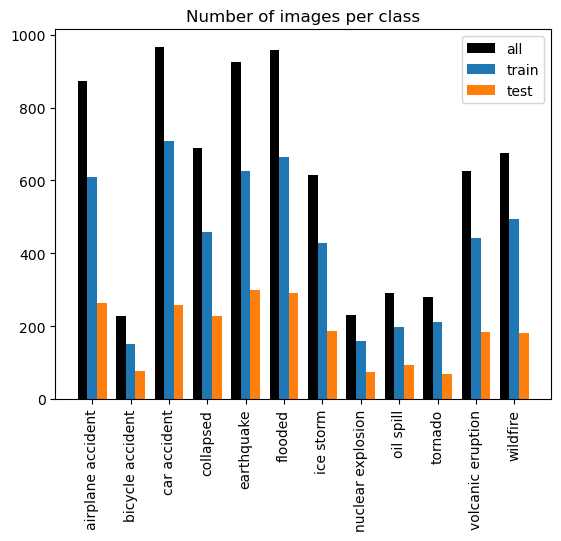

In [8]:
unique_targets, unique_target_counts = np.unique(
    targets,
    return_counts=True
)
unique_targets_train, unique_target_counts_train = np.unique(
    targets_train,
    return_counts=True
)
unique_targets_test, unique_target_counts_test = np.unique(
    targets_test,
    return_counts=True
)

# Assert that train and test set both contain the same number of classes, as subsequent code relies on this assumption
assert len(unique_targets_train) == number_of_classes, "Train set must contain all classes"
assert len(unique_targets_test) == number_of_classes, "Test set must contain all classes"

# Convoluted way of showing a bar chart with multiple bars, but prevents having to create a dataframe for e.g. Seaborn
plt.bar(np.arange(number_of_classes) - 0.25,
        unique_target_counts,
        width=0.25,
        label="all",
        color="black")
plt.bar(np.arange(number_of_classes),
        unique_target_counts_train,
        width=0.25,
        # color="none",
        # edgecolor="black",
        # hatch="----",
        label="train")
plt.bar(np.arange(number_of_classes) + 0.25,
        unique_target_counts_test,
        width=0.25,
        # color="none",
        # edgecolor="black",
        label="test")
plt.xticks(np.arange(number_of_classes),
           labels=data.classes,
           rotation="vertical")
plt.legend()
plt.title("Number of images per class")
plt.show()

The plot shows that the data in the dataset is unbalanced. For example, the "car accident" class sees a much larger occurence than the "nuclear explosion" class. This imbalance could lead to issues later with the model not performing well for certain underrepresented classes. This can be mitigated to some extent by performing data augmentation. This is a process in which images undergo a certain modification, such as a horizontal flip or a rotation, which "augments" the dataset with "new" training images. By doing this for the four clearly most underrepresented classes, we can attempt to improve the model's performance. The classes that will be augmented are "bicycle accident", "nuclear explosion", "oil spill" and "tornado".

### Data augmentation

The augmentations will be performed to grow these classes by 132%, which brings them roughly level with classes such as "volcanic eruption" and "ice storm". For each of the underrepresented classes, two augmentations will be performed on 66% of the images, picked at random from the full class. The first augmentation will be a horizontal flip, the second will a rotation between 10 and 20 degrees. After the augmentations are complete, the augmentation sets will be added to the original image set for the corresponding class.

In [13]:
# Extract the data twice more, once for each augmentation
data_aug1 = torchvision.datasets.ImageFolder(
    './data/Incidents-subset',
    transform=transform,
    is_valid_file=check_Image
)

data_aug2 = torchvision.datasets.ImageFolder(
    './data/Incidents-subset',
    transform=transform,
    is_valid_file=check_Image
)

# Use the same seed as used earlier to ensure the random split is exactly the same
data_train_aug1, _ = torch.utils.data.random_split(
    data_aug1,
    [0.7, 0.3],
    generator=torch.Generator().manual_seed(42)
)

data_train_aug2, _ = torch.utils.data.random_split(
    data_aug2,
    [0.7, 0.3],
    generator=torch.Generator().manual_seed(42)
)

In [14]:
# Define two functions, one for each augmentation
def AugmentHorizontalFlip(underrep_classes, targets, data):
    relevant_image_index_list = []

    for class_id in underrep_classes:
        relevant_image_indices = (np.array(targets) == class_id).nonzero()[0]
        relevant_image_index_list.append(relevant_image_indices)

        # Pick two-thirds of the training images for the underrepresented class at random
        sampled_image_indices = rng.choice(
            a=relevant_image_indices,
            size=int((len(relevant_image_indices)-1)/1.5),
            replace=False
        )

        # Compose the transform, in this case a horizontal flip
        horizontalFlip_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(1),
        ])

        # Apply the transform to each underrepresented class image
        for image_index in sampled_image_indices:
            horizontalFlip_transform(data[image_index][0])

    # Return only a subset of the data to prevent duplicates that were not augmented
    return torch.utils.data.Subset(data, np.concatenate(relevant_image_index_list))


def AugmentRotation(underrep_classes, targets, data):
    relevant_image_index_list = []

    for class_id in underrep_classes:
        relevant_image_indices = (np.array(targets) == class_id).nonzero()[0]
        relevant_image_index_list.append(relevant_image_indices)

        # Pick two-thirds of the training images for the underrepresented class at random
        sampled_image_indices = rng.choice(
            a=relevant_image_indices,
            size=int((len(relevant_image_indices)-1)/1.5),
            replace=False
        )

        # Compose the transform, in this case a rotation between 10 and 20 degrees
        rotation_transform = transforms.Compose([
            transforms.RandomRotation((10, 20)),
        ])

        # Apply the transform to each underrepresented class image
        for image_index in sampled_image_indices:
            rotation_transform(data[image_index][0])

    # Return only a subset of the data to prevent duplicates that were not augmented
    return torch.utils.data.Subset(data, np.concatenate(relevant_image_index_list))

In [15]:
# Define what classes need augmenting
underrep_classes = [1, 7, 8, 9]

# Call the two augmentation functions
data_train_aug1 = AugmentHorizontalFlip(underrep_classes, targets_train, data_train_aug1)
data_train_aug2 = AugmentRotation(underrep_classes, targets_train, data_train_aug2)

# Concatenate the two resulting augmentated datasets to the original set and update the target list
data_train = torch.utils.data.ConcatDataset([data_train, data_train_aug1, data_train_aug2])
targets_train = [target for (_, target) in data_train]

Running the code below shows the result of the augmentation. The original data size is still the same at 7357, but the train set has increased in size without the test set increasing. Further down, the same can be seen in the barplot. It is clearly visible that the previously underrepresented classes are now represented much better, leading to a much more balanced dataset to train the models on.

In [16]:
print(f"Number of items in dataset: {len(data)}")
print(f"Number of items in train set: {len(data_train)}")
print(f"Number of images in test set: {len(data_test)}")
print(f"Number of classes: {number_of_classes}")

Number of items in dataset: 7357
Number of items in train set: 6590
Number of images in test set: 2207
Number of classes: 12


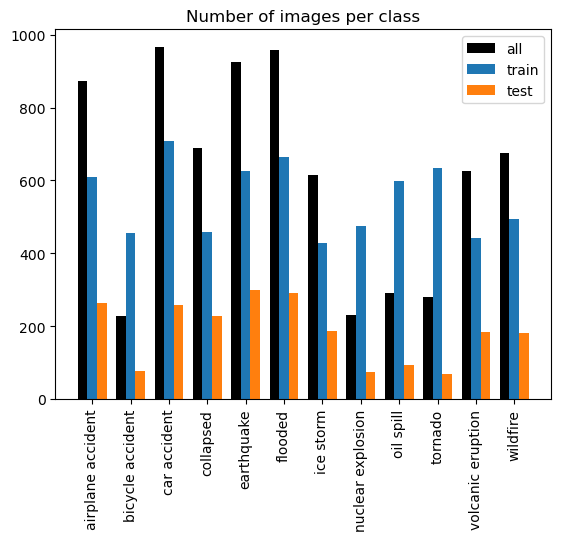

In [18]:
unique_targets, unique_target_counts = np.unique(
    targets,
    return_counts=True
)
unique_targets_train, unique_target_counts_train = np.unique(
    targets_train,
    return_counts=True
)
unique_targets_test, unique_target_counts_test = np.unique(
    targets_test,
    return_counts=True
)

# Assert that train and test set both contain the same number of classes, as subsequent code relies on this assumption
assert len(unique_targets_train) == number_of_classes, "Train set must contain all classes"
assert len(unique_targets_test) == number_of_classes, "Test set must contain all classes"

# Convoluted way of showing a bar chart with multiple bars, but prevents having to create a dataframe for e.g. Seaborn
plt.bar(np.arange(number_of_classes) - 0.25,
        unique_target_counts,
        width=0.25,
        label="all",
        color="black")
plt.bar(np.arange(number_of_classes),
        unique_target_counts_train,
        width=0.25,
        # color="none",
        # edgecolor="black",
        # hatch="----",
        label="train")
plt.bar(np.arange(number_of_classes) + 0.25,
        unique_target_counts_test,
        width=0.25,
        # color="none",
        # edgecolor="black",
        label="test")
plt.xticks(np.arange(number_of_classes),
           labels=data.classes,
           rotation="vertical")
plt.legend()
plt.title("Number of images per class")
plt.show()

### Sample images

As a result of the normalization performed earlier, the images cannot be displayed as-is without clipping. Hence, we need a way to inverse the normalization before displaying the images. We do this through the use of a `Transform`.

In [19]:
class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    Code from https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/8
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())


inverse_normalize = NormalizeInverse(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

Now, we actually visualise the images.

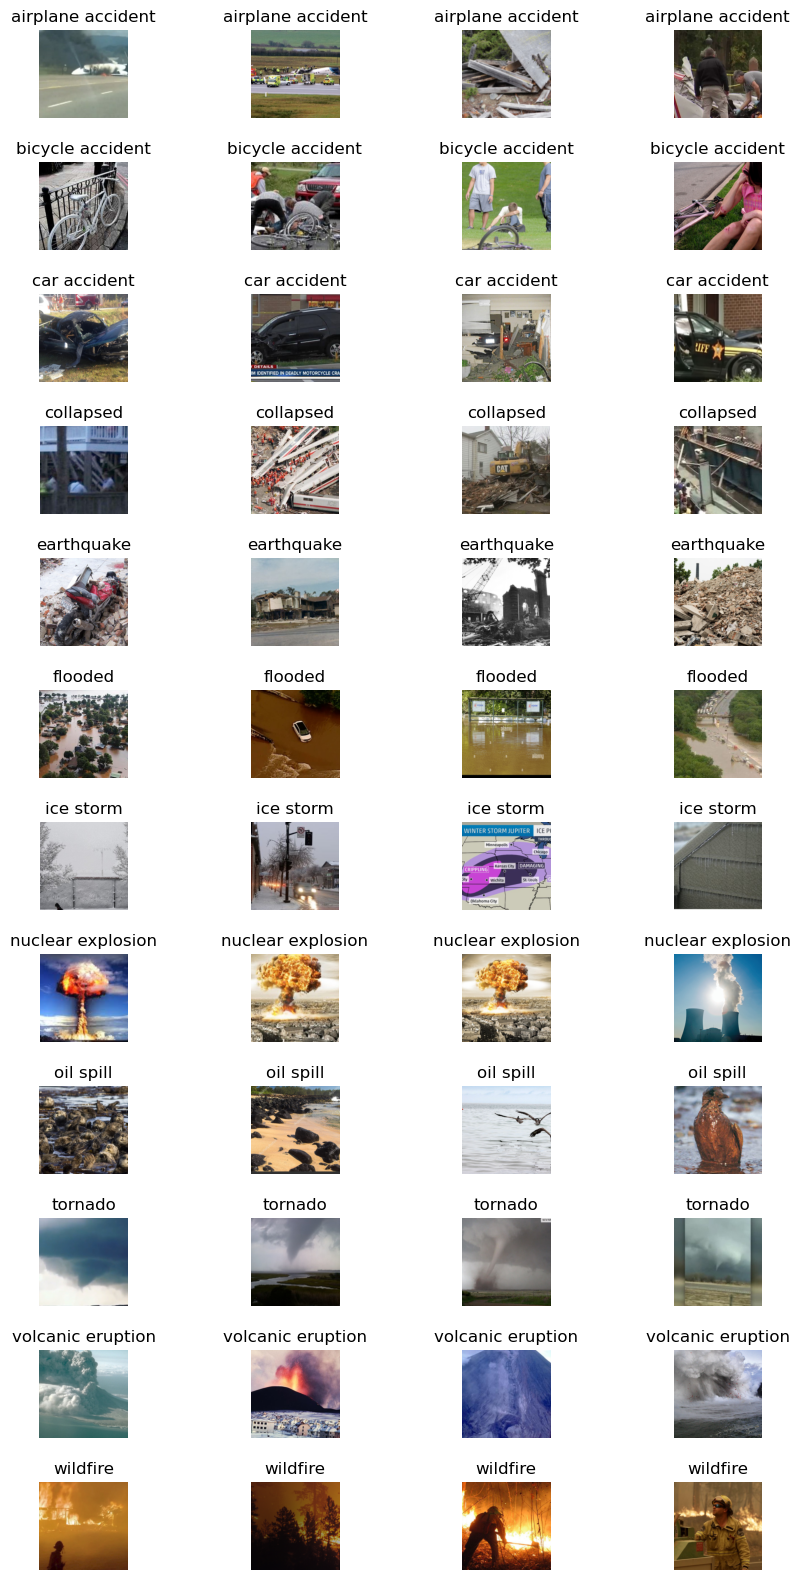

In [20]:
number_of_images_per_class = 4

# Create plots with sufficient size and spacing
fig, axs = plt.subplots(number_of_classes,
                        number_of_images_per_class,
                        figsize=(10, 20))
plt.subplots_adjust(hspace=.5, wspace=.5)

for target_class in range(0, number_of_classes):
    # Create a mask for the dataset to include only images for this class
    relevant_image_indices = (np.array(targets) == target_class).nonzero()[0]

    # Randomly sample images from all relevant images
    sampled_image_indices = rng.choice(
        a=relevant_image_indices,
        size=number_of_images_per_class,
        replace=False
    )

    # Display the images with the proper title
    for i, image_index in enumerate(sampled_image_indices):
        ax = axs[target_class, i]
        ax.imshow(
            # Clamp to prevent values just outside the [0,1] range (as a result of inverse normalisation)
            torch.clamp(inverse_normalize(data[image_index][0]).permute(1,2,0), 0, 1),
            vmin=0,
            vmax=1)
        ax.axis("off")
        ax.set_title(data.classes[target_class])

## Saving the prepared data

To be able to use the data that was prepared in this notebook, it must be saved so it can be loaded in the model notebook. This will be done using torch.save().

In [21]:
if not os.path.exists('./content'):
    os.mkdir('./content')
    os.mkdir('./content/train_loader')
    os.mkdir('./content/test_loader')
    os.mkdir('./content/train_loader/img')
    os.mkdir('./content/train_loader/target')
    os.mkdir('./content/test_loader/img')
    os.mkdir('./content/test_loader/target')

with open('./content/data_classes.bin', 'wb') as file:
    pickle.dump(data.classes, file)

for i, data in enumerate(data_train):
    torch.save(data[0], './content/train_loader/img/train_prepped_img{}'.format(i))
    torch.save(data[1], './content/train_loader/target/train_prepped_target{}'.format(i))

for i, data in enumerate(data_test):
    torch.save(data[0], './content/test_loader/img/test_prepped_img{}'.format(i))
    torch.save(data[1], './content/test_loader/target/test_prepped_target{}'.format(i))